In [1]:
#Import libraries
%matplotlib inline
import os
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.misc import imresize
import keras

Using TensorFlow backend.


In [2]:
#Load images
phototexture    = []

folder=os.getcwd()+'/photos/'+'texture/'
texture_dict = {}

filelist = glob.glob(folder+'/*.png')
textureimages = np.array([imresize(np.array(Image.open(fname).convert('RGBA')),10) for fname in filelist])

In [3]:
texturefiles = np.array([np.array(fname.split('/')[-1].replace('.png','')) for fname in filelist])
texturefiles = list(map(int, texturefiles))

In [4]:
texture = pd.read_csv('texture.csv')
texture = texture.drop(['Unnamed: 0'],axis=1)
texture['texture'] = texture.texture.str.replace(',','.')
texture['texture'] = pd.to_numeric(texture['texture'])
texture['inx']   = texture.index

In [5]:
texturefiles = pd.DataFrame(texturefiles,columns=['inx'])
texturedata = texturefiles.merge(texture,on='inx')

In [6]:
errorimages = [1126,1132,1143]
errorindex  = texturedata[texturedata.inx.isin(errorimages)].index.values
texturedata = texturedata.drop(errorindex)

In [7]:
texturedata = texturedata.drop(['filename','empresa','gravel_size','image','inx'],axis=1)

In [8]:
#texturedata['category'] = pd.cut(texturedata.texture,bins=[-0.01,165,275,350,460,20000],labels=['Polido',
#                                             'Macio', 'Baixa Rugosidade', 'Rugosidade Moderada','Alta Rugosidade'])
texturedata['category'] = pd.cut(texturedata.texture,bins=[-0.01,165,275,350,460,20000],labels=[0, 1, 2, 3, 4])

In [9]:
textureimagesclean = np.delete(textureimages,errorindex,0)

In [10]:
x_train = textureimagesclean[:].astype('float32')/255
y_train = texturedata['category'][:]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [12]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')


x_train shape: (796, 48, 64, 4)
796 train samples
427 test samples
199 validation samples


In [13]:
train_size, length, height, channels = x_train.shape

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height, channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 64, 16)        272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 32, 48)        3120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 16, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 16, 96)        18528     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 8, 96)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 8, 96)          0         
__________

In [15]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [16]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)


In [17]:
hist = model.fit(x_train, y_train, batch_size=10, epochs=100,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 796 samples, validate on 199 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.37365, saving model to model.weights.best.hdf5
3s - loss: 1.4753 - acc: 0.3995 - val_loss: 1.3737 - val_acc: 0.3719
Epoch 2/100
Epoch 00001: val_loss improved from 1.37365 to 1.32370, saving model to model.weights.best.hdf5
3s - loss: 1.3352 - acc: 0.4410 - val_loss: 1.3237 - val_acc: 0.3719
Epoch 3/100
Epoch 00002: val_loss did not improve
3s - loss: 1.2134 - acc: 0.4899 - val_loss: 1.5402 - val_acc: 0.2714
Epoch 4/100
Epoch 00003: val_loss did not improve
3s - loss: 1.1742 - acc: 0.4812 - val_loss: 2.1786 - val_acc: 0.3719
Epoch 5/100
Epoch 00004: val_loss improved from 1.32370 to 1.05356, saving model to model.weights.best.hdf5
2s - loss: 1.1297 - acc: 0.5364 - val_loss: 1.0536 - val_acc: 0.5327
Epoch 6/100
Epoch 00005: val_loss did not improve
2s - loss: 1.0530 - acc: 0.5440 - val_loss: 1.1114 - val_acc: 0.5025
Epoch 7/100
Epoch 00006: val_loss improved from 1.05356 to 0.96010, sa

Epoch 00065: val_loss did not improve
3s - loss: 0.0317 - acc: 0.9912 - val_loss: 3.5731 - val_acc: 0.5729
Epoch 67/100
Epoch 00066: val_loss did not improve
3s - loss: 0.0364 - acc: 0.9874 - val_loss: 3.2941 - val_acc: 0.4824
Epoch 68/100
Epoch 00067: val_loss did not improve
3s - loss: 0.0348 - acc: 0.9862 - val_loss: 3.4431 - val_acc: 0.5427
Epoch 69/100
Epoch 00068: val_loss did not improve
3s - loss: 0.0391 - acc: 0.9824 - val_loss: 3.1710 - val_acc: 0.5427
Epoch 70/100
Epoch 00069: val_loss did not improve
4s - loss: 0.0725 - acc: 0.9862 - val_loss: 2.9434 - val_acc: 0.5678
Epoch 71/100
Epoch 00070: val_loss did not improve
4s - loss: 0.0297 - acc: 0.9912 - val_loss: 3.5264 - val_acc: 0.5528
Epoch 72/100
Epoch 00071: val_loss did not improve
4s - loss: 0.0423 - acc: 0.9874 - val_loss: 3.0855 - val_acc: 0.5377
Epoch 73/100
Epoch 00072: val_loss did not improve
3s - loss: 0.0631 - acc: 0.9837 - val_loss: 3.6913 - val_acc: 0.5678
Epoch 74/100
Epoch 00073: val_loss did not improve
3s

In [18]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [19]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.625292740605


In [20]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
texture_categories = ['Polido','Macio', 'Baixa Rugosidade', 'Rugosidade Moderada','Alta Rugosidade']

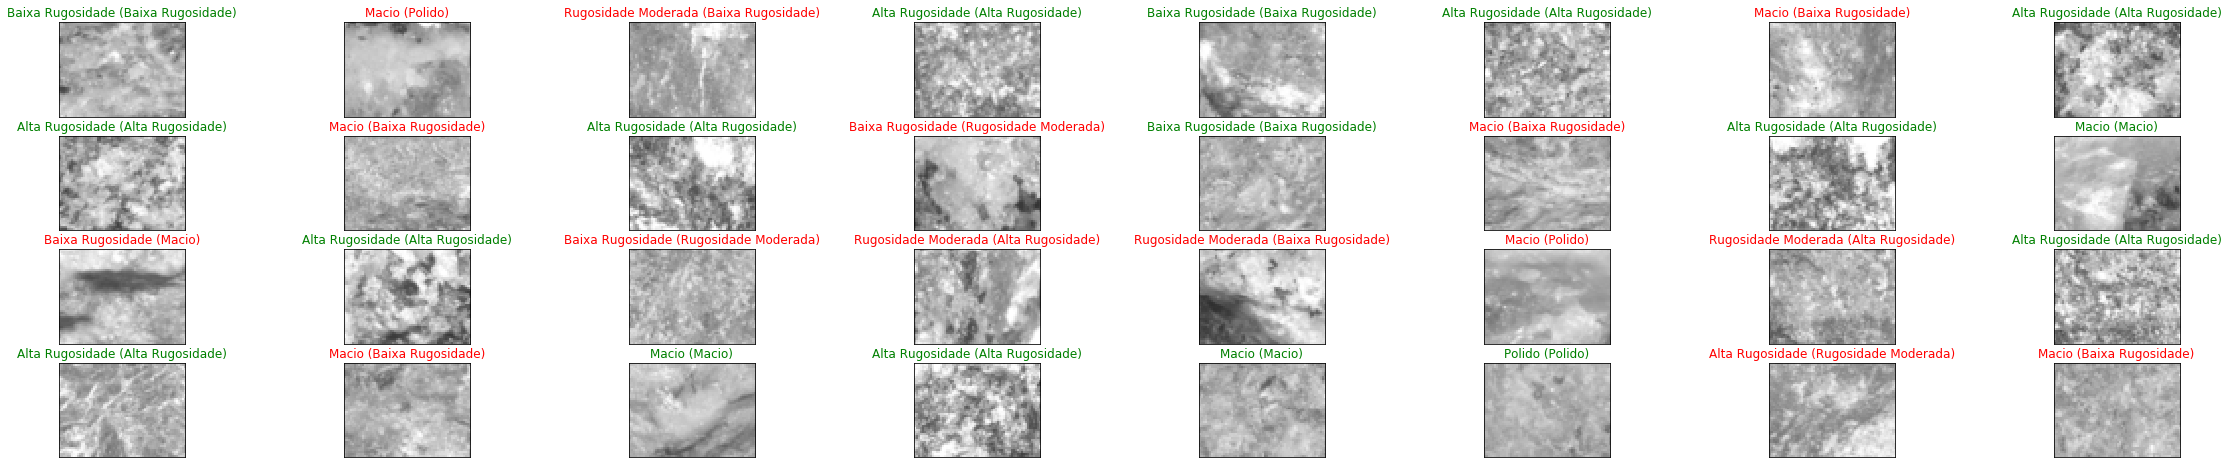

In [24]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(40, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(texture_categories[pred_idx], texture_categories[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))